In [1]:
import pandas as pd
import numpy as np
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
with open("../FeatureStore/TrainingDataset_AllOrders.pickle", "rb") as file:
    trainingDataset = pickle.load(file)

with open("../FeatureStore/TestDataset_AllOrders.pickle", "rb") as file:
    testDataset = pickle.load(file)

In [4]:
trainingDataset["average_reorder_ratio_per_order_user"]

0           0.770238
1           0.770238
2           0.770238
3           0.770238
4           0.770238
              ...   
11667192    0.583333
11667193    0.583333
11667194    0.583333
11667195    0.583333
11667196    0.583333
Name: average_reorder_ratio_per_order_user, Length: 11667197, dtype: float64

In [2]:
COLS = ["user_id", "product_id", 

        "order_number", "last_order_number", "order_dow", "order_hour_of_day", "days_since_prior_order",
        "days_since_prev_order_item", "products_ordered_in_this_order", ## Current order Features

        "total_orders_uxp", "usual_cart_position_uxp", "streak_chance_uxp", "item_n2_chance_uxp", "item_n3_chance_uxp", 
        "item_n4_chance_uxp", "item_n5_chance_uxp", "average_reorder_time_uxp", ## Uxp Features

        "reorder_ratio_product", "total_purchases_product", "usual_position_in_cart_product", "avg_cart_size_product",
        "usual_buying_time_product", "usual_buying_day_product", "one_shot_ratio_product", "unique_users_product", ## Prod Features

        "total_orders_user", "avg_time_between_orders_user", "usual_buying_time_user", "usual_buying_day_user", "total_unique_products_bought_user",
        "first_product_reordered_user", "complete_new_order_user", "average_product_per_order_user", "average_reorder_ratio_per_order_user", ## User Features
        
        "reordered"]


In [3]:
def generateUserFeatures(df):
    user_base_features = df.groupby("user_id").agg(
        total_orders = ("order_number", "max"), ## app liking
        avg_time_between_orders = ("days_since_prior_order", "mean"), ## app loyalty
        usual_buying_time = ("order_hour_of_day", "median"), ## buying pattern
        usual_buying_day = ("order_dow", "median"), ## buying pattern
        total_unique_products_bought = ("product_id", "nunique"), ## new product recommendation
    ).reset_index()

    first_product_reordered = df[((df.cart_order == 1) & (df.order_number != 1))].groupby("user_id")["reordered"].mean().reset_index(name="first_product_reordered")
    user_base_features = user_base_features.merge(first_product_reordered, on="user_id", how="left")

    temp = df[df.order_number != 1].groupby(["user_id", "order_id"])["reordered"].sum().reset_index()
    temp["complete_new_order"] = (temp["reordered"] == 0).astype(int)
    new_order = temp.groupby("user_id")["complete_new_order"].mean().reset_index()
    user_base_features = user_base_features.merge(new_order, on="user_id", how="left")

    user_order_features = df[df.order_number != 1].groupby(["user_id", "order_number"]).agg(
        product_per_order = ("product_id", "count"), ## buying nature
        reorder_ratio_per_order = ("reordered", "mean"),  ## buying nature
    ).reset_index()

    user_order_features = user_order_features.groupby("user_id").agg(
        average_product_per_order = ("product_per_order", "median"), ## buying nature
        average_reorder_ratio_per_order = ("reorder_ratio_per_order", "mean"), ## buying nature
    ).reset_index()

    user_features = user_base_features.merge(user_order_features, on="user_id", how="left")

    del user_order_features, temp, new_order, first_product_reordered, user_base_features
    gc.collect()
    user_features.columns = [col + "_user" if col != "user_id" else col for col in user_features.columns]
    return user_features

def generateProductFeatures(df):
    product_base_features = df.groupby("product_id").agg(
        reorder_ratio = ("reordered", "mean"), ## Product popularity
        total_purchases = ("order_id", "count"), ## Overall interest
        usual_position_in_cart = ("cart_order", "median"), ## Type of product [Needs/Wants/Last minute impulse]
        avg_cart_size = ("cart_size", "mean"), ## Part of staple order or not
        usual_buying_time = ("order_hour_of_day", "median"), ## buying pattern
        usual_buying_day = ("order_dow", "median"), ## buying pattern
    ).reset_index()

    user_product_base_features = df.groupby(["user_id", "product_id"]).agg(
        total_orders = ("order_id", "nunique"), ## Staple/single shots
        usual_cart_position = ("cart_order", "median")).reset_index() ## User's view on this product (Need/Want),

    single_order_ratio = (user_product_base_features[user_product_base_features['total_orders'] == 1].groupby('product_id').size() / user_product_base_features.groupby('product_id').size()).reset_index(name="one_shot_ratio")
    unique_users = user_product_base_features.groupby('product_id').size().reset_index(name="unique_users")
    product_features = product_base_features.merge(single_order_ratio, on="product_id", how="left")
    product_features = product_features.merge(unique_users, on="product_id", how="left")
    product_features["one_shot_ratio"] = product_features["one_shot_ratio"].fillna(0)

    product_features.columns = [col+"_product" if col != "product_id" else col for col in product_features.columns if col]

    del product_base_features, single_order_ratio, unique_users
    gc.collect()
    return product_features

def generateUXPFeatures(df):
    user_product_features = df.groupby(["user_id", "product_id"]).agg(
        total_orders = ("order_id", "nunique"), ## Staple/single shots
        usual_cart_position = ("cart_order", "median"), ## User's view on this product (Need/Want),

        ### Reorder chances within n orders
        streak_chance = ("item_in_every_order", "mean"),
        item_n2_chance = ("item_in_every_2_order", "mean"),
        item_n3_chance = ("item_in_every_3_order", "mean"),
        item_n4_chance = ("item_in_every_4_order", "mean"),
        item_n5_chance = ("item_in_every_5_order", "mean"),
        
        average_reorder_time = ("days_since_prev_order_item", "median")).reset_index() 

    user_product_features["average_reorder_time"] = user_product_features["average_reorder_time"].fillna(0)
    user_product_features.columns = [col+"_uxp" if ((col != "user_id") & (col != "product_id")) else col for col in user_product_features.columns if col]
    return user_product_features

def generateOderFeatures(df):
    ## User - Product usage (Days since last order of this item by this user)
    df["last_order_number"] = df.groupby(['user_id', 'product_id'])["order_number"].shift(1)

    temp = df.drop_duplicates(subset=["user_id", "order_number"])[["user_id", "order_number", "days_since_prior_order"]]
    temp["days_since_first_order"] = temp.groupby(["user_id"])["days_since_prior_order"].cumsum()
    temp["last_order_number"] = temp["order_number"]

    df = df.merge(temp[["user_id", "order_number", "days_since_first_order"]], left_on=["user_id", "order_number"], right_on=["user_id", "order_number"], how="left")
    df = df.rename(columns={"days_since_first_order": "curr_order_days_since_first_order"})

    df = df.merge(temp[["user_id", "last_order_number", "days_since_first_order"]], left_on=["user_id", "last_order_number"], right_on=["user_id", "last_order_number"], how="left")
    df = df.rename(columns={"days_since_first_order": "prev_order_days_since_first_order"})

    df["curr_order_days_since_first_order"] = df["curr_order_days_since_first_order"].fillna(0)
    df["prev_order_days_since_first_order"] = df["reordered"]*(df["last_order_number"]/df["last_order_number"])*df["prev_order_days_since_first_order"].fillna(0)
    df.loc[:,"days_since_prev_order_item"] = df["curr_order_days_since_first_order"] - df["prev_order_days_since_first_order"]

    df = df.drop(["curr_order_days_since_first_order", "prev_order_days_since_first_order"], axis=1)

    df["last_order_num_diff"] = df["order_number"] - df["last_order_number"]
    df["item_in_every_order"] = ((df["order_number"] - df["last_order_number"]) == 1).astype(int)
    df["item_in_every_2_order"] = ((df["order_number"] - df["last_order_number"]) == 2).astype(int)
    df["item_in_every_3_order"] = ((df["order_number"] - df["last_order_number"]) == 3).astype(int)
    df["item_in_every_4_order"] = ((df["order_number"] - df["last_order_number"]) == 4).astype(int)
    df["item_in_every_5_order"] = ((df["order_number"] - df["last_order_number"]) == 4).astype(int)

    order_features = df.groupby("order_id").agg(
        cart_size = ("product_id", "count"), 
        reorder_ratio = ("reordered", "mean"),
    ).reset_index()
    df = df.merge(order_features, left_on="order_id", right_on="order_id")

    del temp
    gc.collect()

    return df

In [4]:
def materializeFeatures(prior):
    user_features = generateUserFeatures(prior)
    product_features = generateProductFeatures(prior)
    uxp_features = generateUXPFeatures(prior)
    data = pd.merge(uxp_features.merge(product_features, on="product_id"), user_features, on="user_id")
    del user_features, product_features, uxp_features
    gc.collect()
    
    return data

def createDataset(prior, currentOrder, cols=COLS):
    data = materializeFeatures(prior)
    currentOrder["products_ordered_in_this_order"] = currentOrder["cart_order"] - 1
    currentOrder = currentOrder[["user_id", "product_id", "order_number", "order_dow", 
                       "order_hour_of_day", "days_since_prior_order", "days_since_prev_order_item", 
                       "last_order_number", "products_ordered_in_this_order", "reordered"]]
    
    df = data.merge(currentOrder, on=["user_id", "product_id"], how="left")

    df = df[COLS]
    del prior, currentOrder
    gc.collect()

    return df

def preprocess(PRIOR_ORDERS, CURRENT_ORDER, col):
    PRIOR_USER_PRODUCT_ORDERS = PRIOR_ORDERS.drop_duplicates(subset=["user_id", "product_id"])[["user_id", "product_id"]]
    CURRENT_USER_PRODUCT_ORDERS = CURRENT_ORDER[["user_id", "product_id", "reordered"]]
    CURRENT_ORDER_MERGED = PRIOR_USER_PRODUCT_ORDERS.merge(CURRENT_USER_PRODUCT_ORDERS, on=["user_id", "product_id", ], how="left").sort_values(by=["user_id"]).reset_index(drop=True)
    CURRENT_ORDER_MERGED["reordered"] = CURRENT_ORDER_MERGED["reordered"].fillna(0)
    reordered = CURRENT_ORDER_MERGED["reordered"]
    CURRENT_ORDER_MERGED["reordered"] = 1
    CURRENT_ORDER_MERGED = CURRENT_ORDER_MERGED.merge(CURRENT_ORDER.drop_duplicates(["user_id"])[["order_id", "user_id", "order_number", "order_dow", "order_hour_of_day", "days_since_prior_order", "max_onb", "train", "test"]], on="user_id", how="left")

    ORDERS = pd.concat([PRIOR_ORDERS, CURRENT_ORDER_MERGED], ignore_index=True)
    ORDERS = generateOderFeatures(ORDERS)

    PRIORS = ORDERS[ORDERS.order_number < ORDERS[col]].drop(["train", "test"], axis=1).reset_index(drop=True)
    CURRENT = ORDERS[ORDERS.order_number == ORDERS[col]].drop(["train", "test"], axis=1).reset_index(drop=True)
    CURRENT["reordered"] = reordered
    CURRENT["cart_order"] = CURRENT["cart_order"].fillna(1)

    del PRIOR_USER_PRODUCT_ORDERS, CURRENT_USER_PRODUCT_ORDERS, CURRENT_ORDER_MERGED, ORDERS, reordered
    gc.collect()
    return PRIORS, CURRENT

def setup(data, trainMinOrders=3):
    max_onb = data.groupby("user_id")["order_number"].max().reset_index(name="max_onb")
    data = data.merge(max_onb, on="user_id")

    data["train"] = np.maximum(data["max_onb"] - 1, trainMinOrders) ## Atleast 3 orders required in prior
    data["test"] = np.maximum(data["max_onb"], trainMinOrders+1) ### Last order as test set

    train_priors = data[data.order_number < data.train].reset_index(drop=True) 
    train = data[data.order_number == data.train].reset_index(drop=True)

    test_priors = data[data.order_number < (data.train + 1)].reset_index(drop=True)
    test = data[data.order_number == (data.train + 1)].reset_index(drop=True)

    train_priors, train = preprocess(train_priors, train, "train")
    test_priors, test = preprocess(test_priors, test, "test")

    trainDataset = createDataset(train_priors, train)
    testDataset = createDataset(test_priors, test)

    del train_priors, test_priors, train, test, data, max_onb, 
    return trainDataset, testDataset

### Will User Reorder ???? 

In [153]:
data = pd.read_csv("../Dataset/Subset.csv", index_col=0).reset_index(drop=True)
train = (data.groupby("user_id")["order_number"].max()).reset_index(name="train")
data = data.merge(train, on="user_id", how="left")

priorOrders = data[data.order_number < data.train].reset_index(drop=True)
willReorder = data[data.order_number == data.train].reset_index(drop=True).groupby("user_id")["reordered"].max().reset_index(name="willReorder")
trainingData = data[data.order_number == data.train].drop_duplicates(subset=["user_id"]).drop(["product_id", "cart_order", "reordered", "train"], axis=1)
trainingData = trainingData.merge(willReorder, on="user_id")
userFeatures = generateUserFeatures(priorOrders)
trainingData = userFeatures.merge(trainingData, on="user_id", how="left")

In [121]:
FEATURES = ["total_orders_user", "avg_time_between_orders_user", "usual_buying_time_user", "usual_buying_day_user", 
            "total_unique_products_bought_user", "first_product_reordered_user", "complete_new_order_user", "average_product_per_order_user",
            "average_reorder_ratio_per_order_user", "order_number", "order_dow", "order_hour_of_day", "days_since_prior_order"]
TARGET = "willReorder"

X_train = trainingData[FEATURES]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = trainingData[TARGET]

In [122]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
trainingData["willReorderPred"] = y_pred

### If yes, what will he reorder ? 

In [5]:
data = pd.read_csv("../Dataset/Subset.csv", index_col=0).reset_index(drop=True)
train, test = setup(data, 3)

In [11]:
FEATURES = [
    "order_number", "last_order_number", "order_dow", "order_hour_of_day", "days_since_prior_order",
    "days_since_prev_order_item", ## Current order Features

    "total_orders_uxp", "usual_cart_position_uxp", "streak_chance_uxp", "item_n2_chance_uxp", "item_n3_chance_uxp", 
    "item_n4_chance_uxp", "item_n5_chance_uxp", "average_reorder_time_uxp", ## Uxp Features

    "reorder_ratio_product", "total_purchases_product", "usual_position_in_cart_product", "avg_cart_size_product",
    "usual_buying_time_product", "usual_buying_day_product", "one_shot_ratio_product", "unique_users_product", ## Prod Features

    "total_orders_user", "avg_time_between_orders_user", "usual_buying_time_user", "usual_buying_day_user", "total_unique_products_bought_user",
    "first_product_reordered_user", "complete_new_order_user", "average_product_per_order_user", "average_reorder_ratio_per_order_user", ## User Features
]
TARGET = "reordered"

X_train = train[FEATURES]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = train[TARGET]

In [12]:
model2 = LogisticRegression()
model2.fit(X_train, y_train)
y_pred = model2.predict(X_train)
train["reordered_pred"] = y_pred

/Users/sid98/OMSA/06_ISYE_6740_CDA/Project/instacart/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [126]:
train = train.merge(trainingData[["user_id", "willReorderPred"]], on="user_id")

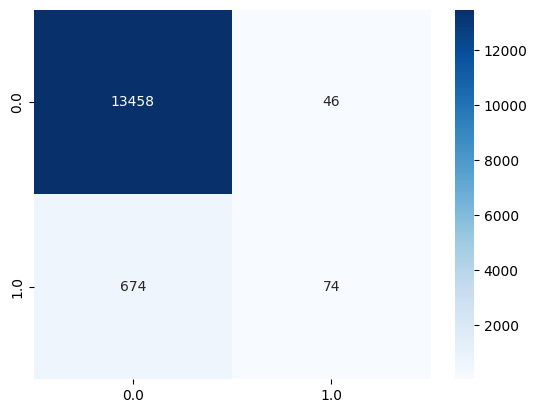

In [127]:
cm = confusion_matrix(y_train, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model2.classes_, yticklabels=model2.classes_)
plt.show()

In [129]:
train["reordered_pred"] = train.apply(lambda x: 0 if x["willReorderPred"] == 0 else x["reordered_pred"], axis=1)

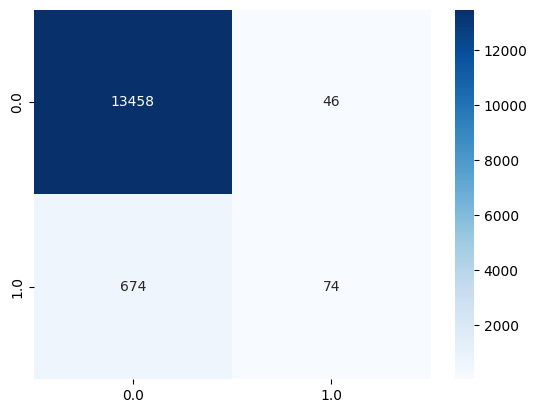

In [130]:
y_pred_2 = train["reordered"].values
cm = confusion_matrix(y_train, y_pred_2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model2.classes_, yticklabels=model2.classes_)
plt.show()

In [14]:

train[train.user_id == 122455][["product_id", "reordered", "reordered_pred"]]

,product_id,reordered,reordered_pred
7620,8571,1.0,0.0
7621,19660,0.0,0.0
7622,21769,0.0,0.0
7623,30751,1.0,0.0
7624,32971,1.0,0.0
7625,33000,0.0,0.0
7626,33378,0.0,0.0
7627,42791,1.0,0.0


In [8]:
data[((data.user_id == 122455) & (data.order_number < 8))].product_id.unique()

array([42791, 33378, 21769, 19660, 33000, 32971,  8571, 30751])

In [9]:
data[((data.user_id == 122455) & (data.order_number == 8))]

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,cart_order,reordered
27374,1177238,122455,8,4,12,0.0,42791,1,1
27375,1177238,122455,8,4,12,0.0,32971,2,1
27376,1177238,122455,8,4,12,0.0,8571,3,1
27377,1177238,122455,8,4,12,0.0,30751,4,1


In [70]:
import numpy as np
from itertools import combinations, groupby
from collections import Counter

In [71]:
import numpy as np
from itertools import combinations, groupby
from collections import Counter

orders = data.set_index('order_id')['product_id'].rename('item_id')
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().values
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns] 

In [72]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))

    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100
    

    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))

    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))
    

    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [74]:
orders = data.set_index('order_id')['product_id'].rename('item_id')
rules = association_rules(orders, 0.1)

Starting order_item:                  51713
Items with support >= 0.1:            2201
Remaining order_item:                 44357
Remaining orders with 2+ items:        4681
Remaining order_item:                 44133
Item pairs:                          160669
Item pairs with support >= 0.1:      10239



In [84]:
metadata = pd.read_csv("../Dataset/Metadata.csv", index_col=0)

In [85]:
metadata

,product_id,product_name,department,aisle
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes
1,2,All-Seasons Salt,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,frozen,frozen meals
4,5,Green Chile Anytime Sauce,pantry,marinades meat preparation
...,...,...,...,...
49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",alcohol,spirits
49684,49685,En Croute Roast Hazelnut Cranberry,frozen,frozen vegan vegetarian
49685,49686,Artisan Baguette,bakery,bread
49686,49687,Smartblend Healthy Metabolism Dry Cat Food,pets,cat food care


In [86]:
rules = rules.merge(metadata, left_on="item_A", right_on="product_id", suffixes=("", "_A"))
rules = rules.merge(metadata, left_on="item_B", right_on="product_id", suffixes=("", "_B"))

In [88]:
rules.loc[100:200]

,item_A,item_B,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift,product_id,product_name,department,aisle,product_id_B,product_name_B,department_B,aisle_B
100,38395,22139,5,0.106815,18,0.384533,7,0.149541,0.277778,0.714286,1.857540,38395,BBQ,snacks,chips pretzels,22139,Dark Corn Syrup,pantry,honeys syrups nectars
101,10889,41592,5,0.106815,9,0.192267,14,0.299081,0.555556,0.357143,1.857540,10889,No Pulp Calcium + Vitamin D 100% Pure Orange J...,beverages,refrigerated,41592,Pampers Baby Dry Jumbo Size 3,babies,diapers wipes
102,32742,15950,5,0.106815,14,0.299081,9,0.192267,0.357143,0.555556,1.857540,32742,Cold Pressed Vanilla Cinnamon Agave Cashew Milk,dairy eggs,soy lactosefree,15950,Chik'n Nuggets,frozen,frozen vegan vegetarian
103,9507,40469,5,0.106815,18,0.384533,7,0.149541,0.277778,0.714286,1.857540,9507,Honey Turkey Breast,deli,lunch meat,40469,Strawberry Flavored Organic Z Fruit Rope,snacks,fruit vegetable snacks
104,34134,8186,6,0.128178,17,0.363170,9,0.192267,0.352941,0.666667,1.835686,34134,Spinach Peas & Pear Stage 2 Baby Food,babies,baby food formula,8186,"Baby Food Pouch - Butternut Squash, Carrot & C...",babies,baby food formula
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,43560,20845,5,0.106815,8,0.170904,20,0.427259,0.625000,0.250000,1.462813,43560,"Crackers, Oyster",snacks,crackers,20845,Premium Organic Pasta Sauce Family Marinara,dry goods pasta,pasta sauce
197,25195,11249,9,0.192267,24,0.512711,12,0.256355,0.375000,0.750000,1.462813,25195,Roasted Garlic Loaf,bakery,bread,11249,Nacho Cheese & Bean Snacks,frozen,frozen appetizers sides
198,7256,33754,7,0.149541,16,0.341807,14,0.299081,0.437500,0.500000,1.462813,7256,Light & Fit Greek Raspberry Chocolate,dairy eggs,yogurt,33754,Total 2% with Strawberry Lowfat Greek Strained...,dairy eggs,yogurt
199,26080,14211,7,0.149541,15,0.320444,15,0.320444,0.466667,0.466667,1.456311,26080,Corn & Butternut Squash Stage 2,babies,baby food formula,14211,Baby Food Stage 2 Pumpkin Banana,babies,baby food formula
